In [8]:
import sys
import os
import gc
import ray
import pickle
import numpy as np
import pandas as pd
from ecgdetectors import Detectors
import biosppy.signals.ecg as bsp_ecg
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [10]:
data = []
with open('windows_data.pkl', 'rb') as pickle_file:
    try:
        while True:
            data.append(pickle.load(pickle_file))
    except EOFError:
        pass

In [11]:
i = 5000
print(str(data[i]['label']))
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(data[i]['window']))), y=data[i]['window'], mode='lines', name='Sine Wave'))


1.0


# Train test split

In [12]:
data = pd.DataFrame(data)

In [13]:
test_records = ['114001']
valid_records = ['124001']

df_test = data.loc[data['record'].isin(test_records)]
df_valid = data.loc[data['record'].isin(valid_records)]
df_train = data.loc[~data['record'].isin(test_records + valid_records)]
del data

print('Train')
print(df_train['label'].value_counts())

print('\nValidation')
print(df_valid['label'].value_counts())

print('\nTest')
print(df_test['label'].value_counts())

Train
label
1.0    5870
3.0    4948
2.0    4913
Name: count, dtype: int64

Validation
label
2.0    76
1.0    42
3.0    24
Name: count, dtype: int64

Test
label
1.0    229
3.0     83
2.0     51
Name: count, dtype: int64


In [16]:
x_tr = np.array(df_train['window'].copy())
x_val = np.array(df_valid['window'].copy())
x_te = np.array(df_test['window'].copy())

x_tr = np.array([np.array(val).reshape(-1,1) for val in x_tr])
x_val = np.array([np.array(val).reshape(-1,1) for val in x_val])
x_te = np.array([np.array(val).reshape(-1,1) for val in x_te])

In [17]:
x_tr.shape

(15731, 1250, 1)

In [18]:
y_tr = np.array(df_train['label'].copy())
y_val = np.array(df_valid['label'].copy())
y_te = np.array(df_test['label'].copy())

y_tr = np.array([2 if val >= 2 else val for val in y_tr])
y_val = np.array([2 if val >= 2 else val for val in y_val])
y_te = np.array([2 if val >= 2 else val for val in y_te])

In [19]:
y_tr = pd.get_dummies(y_tr).astype(int)
y_val = pd.get_dummies(y_val).astype(int)
y_te = pd.get_dummies(y_te).astype(int)

In [20]:
y_tr

,1.0,2.0
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
15726,1,0
15727,1,0
15728,1,0
15729,1,0


# TiDE Classifier

In [3]:
import tensorflow as tf
import keras
from keras import Model, Input
from keras.layers import Dense, Dropout, Add, LayerNormalization, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

2024-10-01 19:39:50.659903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 19:39:50.798025: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 19:39:50.837215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 19:39:51.064718: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 19:39:52.365800: W tensorflow/compiler/tf2

In [15]:
precision_class_0 = keras.metrics.Precision(class_id=0)

I0000 00:00:1727728760.862739  158462 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727728760.933655  158462 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727728760.933925  158462 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727728760.935301  158462 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [16]:
def residual_block(input_, hiddenSize, dropoutLevel, LNorm=True):
    x = Dense(units=hiddenSize, activation='relu')(input_)
    x = Dense(units=hiddenSize)(x)
    x = Dropout(dropoutLevel)(x)
    
    x2 = Dense(units=hiddenSize)(input_)
    output = Add()([x, x2])
    
    if LNorm:
        output = LayerNormalization()(output)
    
    return output

In [17]:
def TiDE(numEncoderLayers, hiddenSize, dropoutLevel, LNorm=True):
    y = Input(shape=(1250,))
    output = y
    
    for _ in range(numEncoderLayers):
        output = residual_block(output, hiddenSize, dropoutLevel, LNorm)
    
    output = Dense(units=2, activation='softmax')(output)
    
    model = Model(inputs=y, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[precision_class_0])
    
    return model

In [18]:
neurons = [16, 32, 64, 128]
layers = [1, 2, 3]
dropout = [0.1, 0.2]
best_score = 0

# Hyperparameter selection with grid search

for neuron in neurons:
    for layer in layers:
        for d in dropout:

            tide = TiDE(layer, neuron, d)

            es = EarlyStopping(monitor="val_precision", mode='max', verbose=0, patience=10)

            history = tide.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=30, batch_size = 32, 
                                callbacks=[es], verbose=1)
            
            score = max(list(history.history["val_precision"]))
            if score > best_score:
                best_score = score
                params = [neuron, layer, d]

Epoch 1/30


I0000 00:00:1727728762.810915  158534 service.cc:146] XLA service 0x7677f8003690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727728762.810943  158534 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-09-30 17:39:22.844791: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-30 17:39:22.982787: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


115/492 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7359 - precision: 0.5124

I0000 00:00:1727728764.105663  158534 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


492/492 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.6180 - precision: 0.5562 - val_loss: 0.7793 - val_precision: 0.2963
Epoch 2/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4239 - precision: 0.7099 - val_loss: 0.8435 - val_precision: 0.2857
Epoch 3/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3602 - precision: 0.7798 - val_loss: 0.8135 - val_precision: 0.3333
Epoch 4/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3026 - precision: 0.8297 - val_loss: 0.9777 - val_precision: 0.1951
Epoch 5/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2721 - precision: 0.8455 - val_loss: 1.0505 - val_precision: 0.2051
Epoch 6/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2451 - precision: 0.8575 - val_loss: 1.1368 - val_precision: 0.2812
Epoch 7/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2258 - precision: 0.8785 - val_loss: 1.1757 - val_precision: 0.2222
Epoch 8/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2073 - precision: 0.8890 - val_loss: 1.

In [20]:
params

[16, 1, 0.2]

In [21]:
tide = TiDE(1, 16, 0.2)

checkpoint = ModelCheckpoint('_weights_model.keras', monitor="val_precision", verbose=0,
                            save_best_only=True, mode='max')

history = tide.fit(x_tr, y_tr, validation_data=(x_val, y_val), epochs=50, batch_size = 32, 
                    callbacks=[checkpoint], verbose=1)

Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6122 - precision: 0.5345 - val_loss: 0.7535 - val_precision: 0.2593
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4252 - precision: 0.6991 - val_loss: 0.9095 - val_precision: 0.2769
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3673 - precision: 0.7686 - val_loss: 0.9432 - val_precision: 0.2745
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3228 - precision: 0.7998 - val_loss: 1.0535 - val_precision: 0.2128
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2815 - precision: 0.8340 - val_loss: 1.1361 - val_precision: 0.2143
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2571 - precision: 0.8425 - val_loss: 1.1328 - val_precision: 0.3333
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2356 - precision: 0.8673 - val_loss: 1.1918 - val_precision: 0.2895
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2186 - precision: 0.8773 - v

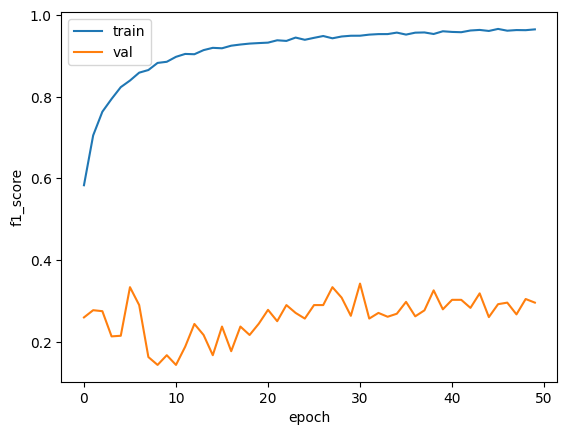

In [22]:
plt.plot(history.history["precision"])
plt.plot(history.history["val_precision"])
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [4]:
tide = keras.saving.load_model('/home/gabrielsaores/Documents/backup_pc_corrompido/ECG Quality/_weights_model.keras')

I0000 00:00:1727822396.406902    3465 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727822396.863107    3465 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727822396.863572    3465 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727822396.865628    3465 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [21]:
tide.predict(x_te)

I0000 00:00:1727822444.322906    4777 service.cc:146] XLA service 0x7f9178001f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727822444.322929    4777 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-10-01 19:40:44.339868: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-01 19:40:44.424160: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 1/12 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step

I0000 00:00:1727822444.725078    4777 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


array([[9.25290406e-01, 7.47095346e-02],
       [9.94668305e-01, 5.33167133e-03],
       [2.56423771e-01, 7.43576288e-01],
       [1.04582973e-01, 8.95417035e-01],
       [3.99384201e-01, 6.00615799e-01],
       [1.06872022e-02, 9.89312828e-01],
       [5.25665190e-03, 9.94743347e-01],
       [5.75012341e-02, 9.42498684e-01],
       [9.30196862e-08, 9.99999881e-01],
       [7.23677189e-08, 9.99999881e-01],
       [1.65803385e-06, 9.99998331e-01],
       [1.11677721e-07, 9.99999881e-01],
       [2.60642906e-07, 9.99999762e-01],
       [7.23399694e-07, 9.99999285e-01],
       [1.03718287e-06, 9.99998927e-01],
       [9.27239125e-06, 9.99990702e-01],
       [1.18180469e-05, 9.99988198e-01],
       [1.43326099e-06, 9.99998569e-01],
       [9.70987548e-06, 9.99990344e-01],
       [4.18552049e-02, 9.58144724e-01],
       [1.88155070e-07, 9.99999762e-01],
       [1.05513131e-07, 9.99999881e-01],
       [1.31456446e-07, 9.99999881e-01],
       [7.96584132e-08, 9.99999881e-01],
       [8.710684

In [39]:
y_pred = tide.predict(x_te)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = [1,2]
y_pred = y_pred.idxmax(axis=1)

y = y_te.copy()
y.columns = [1, 2]
y = y.idxmax(axis=1)
y = y.astype(int)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


# Results of the prediction without threshold

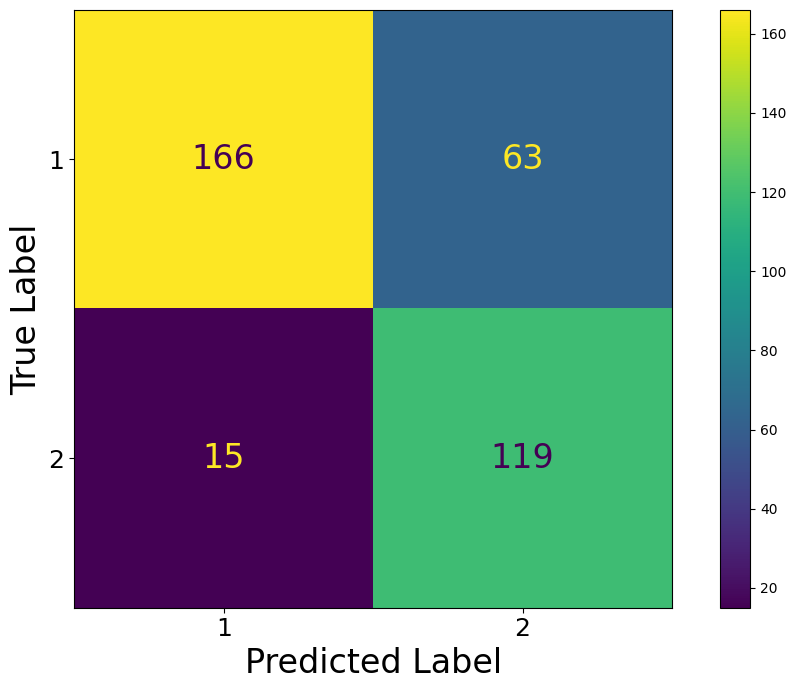

              precision    recall  f1-score   support

           1       0.92      0.72      0.81       229
           2       0.65      0.89      0.75       134

    accuracy                           0.79       363
   macro avg       0.79      0.81      0.78       363
weighted avg       0.82      0.79      0.79       363



In [40]:
cf_matrix = confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(10, 7))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['1', '2'])
cm_display.plot(ax=ax, values_format='d')

ax.set_xlabel('Predicted Label', fontsize=24)
ax.set_ylabel('True Label', fontsize=24)

ax.tick_params(axis='both', which='major', labelsize=18)

for text in ax.texts:
    text.set_fontsize(24)


plt.tight_layout()

plt.savefig('classifier_results.png', dpi=300)
plt.show()

relatorio = classification_report(y, y_pred, target_names=['1', '2'])
print(relatorio)

## Adding a threshold of 0.99 and repeating the prediction

In [28]:
y_pred = tide.predict(x_te)
aux = []
threshold = 0.99
for idx, row in enumerate(y_pred):
    if row[0] > threshold:
        aux.append(1)
    else:
        aux.append(2)

y_pred = aux
del aux    

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


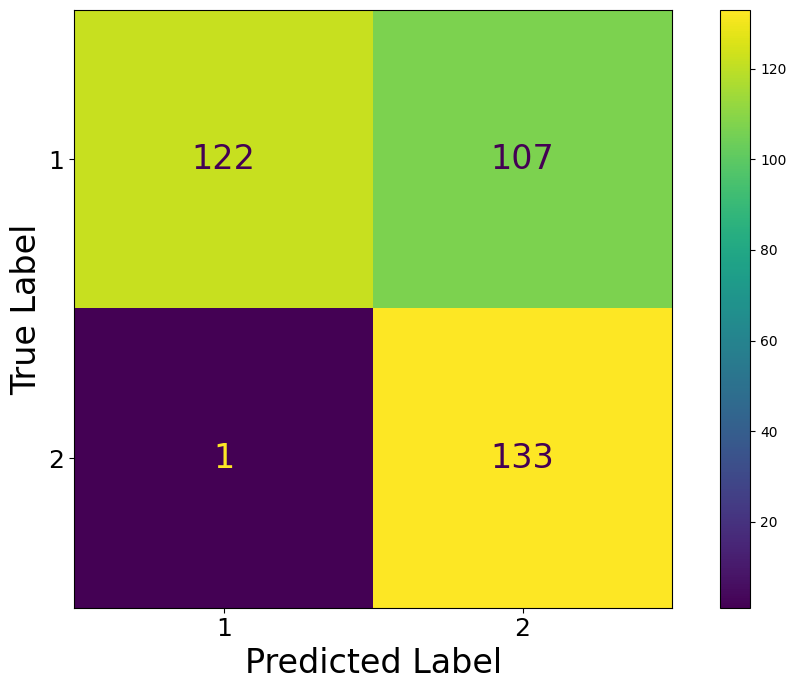

              precision    recall  f1-score   support

           1       0.99      0.53      0.69       229
           2       0.55      0.99      0.71       134

    accuracy                           0.70       363
   macro avg       0.77      0.76      0.70       363
weighted avg       0.83      0.70      0.70       363



In [37]:
cf_matrix = confusion_matrix(y, y_pred)
fig, ax = plt.subplots(figsize=(10, 7))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=['1', '2'])
cm_display.plot(ax=ax, values_format='d')

ax.set_xlabel('Predicted Label', fontsize=24)
ax.set_ylabel('True Label', fontsize=24)

ax.tick_params(axis='both', which='major', labelsize=18)

for text in ax.texts:
    text.set_fontsize(24)


plt.tight_layout()

plt.savefig('classifier_results2.png', dpi=300)
plt.show()

relatorio = classification_report(y, y_pred, target_names=['1', '2'])
print(relatorio)